# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [15]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [16]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [20]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    #Resize Images and convert them to tensor
    transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()])
    #Initialize dataloader
    image_data = datasets.ImageFolder(data_dir,transform)
    data_loader = torch.utils.data.DataLoader(image_data, batch_size,shuffle=True,num_workers=1)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [21]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

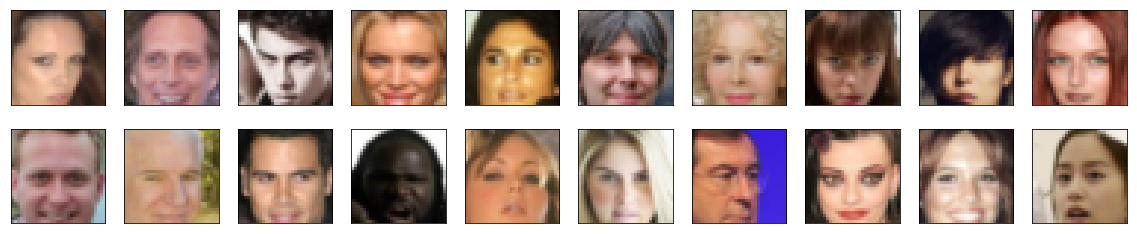

In [22]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [23]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x*(feature_range[1]-feature_range[0])+feature_range[0]
    return x


In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8588)
Max:  tensor(0.9843)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [29]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        # cascade of convolutional layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # final, fully-connected layer output layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)   
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [30]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [32]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [36]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [59]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64 
z_size = 250

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=250, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [61]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [62]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [63]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            ##
            #Train Discriminator
            ##
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_real_loss = real_loss(D(real_images))

            # 2. Train the generator with an adversarial loss
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
                
            D_fake = D(G(z))
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss+d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            ##
            #Train Generator
            ##
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [64]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.6248 | g_loss: 1.1905
Epoch [    1/  100] | d_loss: 0.4956 | g_loss: 8.6460
Epoch [    1/  100] | d_loss: 0.1766 | g_loss: 5.1150
Epoch [    1/  100] | d_loss: 0.1923 | g_loss: 4.2309
Epoch [    1/  100] | d_loss: 0.3972 | g_loss: 5.5700
Epoch [    1/  100] | d_loss: 0.3905 | g_loss: 4.4107
Epoch [    1/  100] | d_loss: 0.6224 | g_loss: 3.2012
Epoch [    1/  100] | d_loss: 0.4750 | g_loss: 3.0825
Epoch [    1/  100] | d_loss: 0.3787 | g_loss: 2.8622
Epoch [    1/  100] | d_loss: 0.5412 | g_loss: 1.5772
Epoch [    1/  100] | d_loss: 2.2193 | g_loss: 0.8941
Epoch [    1/  100] | d_loss: 0.5010 | g_loss: 2.2926
Epoch [    1/  100] | d_loss: 0.4762 | g_loss: 3.0336
Epoch [    1/  100] | d_loss: 0.7154 | g_loss: 3.8594
Epoch [    1/  100] | d_loss: 1.0454 | g_loss: 5.4394
Epoch [    1/  100] | d_loss: 0.8093 | g_loss: 1.7534
Epoch [    1/  100] | d_loss: 0.8641 | g_loss: 2.9109
Epoch [    1/  100] | d_loss: 0.7319 | g_loss: 2.5975
Epoch [    1/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.6759 | g_loss: 1.3882
Epoch [    3/  100] | d_loss: 0.6393 | g_loss: 0.9270
Epoch [    3/  100] | d_loss: 0.8531 | g_loss: 1.2065
Epoch [    3/  100] | d_loss: 0.3600 | g_loss: 1.9908
Epoch [    3/  100] | d_loss: 1.0580 | g_loss: 1.7519
Epoch [    3/  100] | d_loss: 0.6637 | g_loss: 1.8040
Epoch [    3/  100] | d_loss: 0.7000 | g_loss: 2.1853
Epoch [    3/  100] | d_loss: 1.0053 | g_loss: 1.7091
Epoch [    3/  100] | d_loss: 1.0001 | g_loss: 2.5314
Epoch [    3/  100] | d_loss: 0.8574 | g_loss: 0.7150
Epoch [    3/  100] | d_loss: 0.7210 | g_loss: 0.6750
Epoch [    3/  100] | d_loss: 0.9642 | g_loss: 1.3871
Epoch [    3/  100] | d_loss: 1.0435 | g_loss: 0.8084
Epoch [    3/  100] | d_loss: 0.7041 | g_loss: 1.8069
Epoch [    3/  100] | d_loss: 0.9692 | g_loss: 1.3483
Epoch [    3/  100] | d_loss: 0.7855 | g_loss: 1.5705
Epoch [    3/  100] | d_loss: 0.6216 | g_loss: 2.8475
Epoch [    3/  100] | d_loss: 0.8470 | g_loss: 1.5180
Epoch [    3/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.4576 | g_loss: 1.9251
Epoch [    6/  100] | d_loss: 1.6092 | g_loss: 4.6367
Epoch [    6/  100] | d_loss: 0.2968 | g_loss: 3.1287
Epoch [    6/  100] | d_loss: 0.2930 | g_loss: 2.0367
Epoch [    6/  100] | d_loss: 0.6863 | g_loss: 1.6885
Epoch [    6/  100] | d_loss: 0.5088 | g_loss: 1.5444
Epoch [    6/  100] | d_loss: 0.6501 | g_loss: 3.8411
Epoch [    6/  100] | d_loss: 0.4223 | g_loss: 2.3969
Epoch [    6/  100] | d_loss: 0.5336 | g_loss: 2.0177
Epoch [    6/  100] | d_loss: 0.5119 | g_loss: 3.2524
Epoch [    6/  100] | d_loss: 0.3795 | g_loss: 4.1913
Epoch [    6/  100] | d_loss: 0.6538 | g_loss: 3.2213
Epoch [    6/  100] | d_loss: 0.5810 | g_loss: 1.5154
Epoch [    6/  100] | d_loss: 0.7847 | g_loss: 1.1203
Epoch [    6/  100] | d_loss: 0.6652 | g_loss: 1.6607
Epoch [    6/  100] | d_loss: 0.5471 | g_loss: 2.5599
Epoch [    6/  100] | d_loss: 0.4007 | g_loss: 2.7089
Epoch [    6/  100] | d_loss: 0.6293 | g_loss: 1.7967
Epoch [    6/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.9157 | g_loss: 5.0546
Epoch [    9/  100] | d_loss: 0.2424 | g_loss: 2.8037
Epoch [    9/  100] | d_loss: 0.1993 | g_loss: 3.6754
Epoch [    9/  100] | d_loss: 0.4513 | g_loss: 3.3271
Epoch [    9/  100] | d_loss: 0.1560 | g_loss: 4.3193
Epoch [    9/  100] | d_loss: 0.5099 | g_loss: 2.4203
Epoch [    9/  100] | d_loss: 0.3954 | g_loss: 2.2609
Epoch [    9/  100] | d_loss: 0.4083 | g_loss: 2.2193
Epoch [    9/  100] | d_loss: 0.1790 | g_loss: 3.4553
Epoch [    9/  100] | d_loss: 0.3966 | g_loss: 2.0655
Epoch [    9/  100] | d_loss: 0.2441 | g_loss: 3.7542
Epoch [    9/  100] | d_loss: 0.8920 | g_loss: 3.1019
Epoch [    9/  100] | d_loss: 0.4078 | g_loss: 1.4522
Epoch [    9/  100] | d_loss: 0.2134 | g_loss: 3.3854
Epoch [    9/  100] | d_loss: 0.7534 | g_loss: 1.6427
Epoch [    9/  100] | d_loss: 0.2835 | g_loss: 2.5515
Epoch [    9/  100] | d_loss: 0.1544 | g_loss: 3.0723
Epoch [    9/  100] | d_loss: 0.6369 | g_loss: 2.1103
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.4567 | g_loss: 6.0519
Epoch [   11/  100] | d_loss: 0.2512 | g_loss: 4.5186
Epoch [   11/  100] | d_loss: 0.2666 | g_loss: 2.4390
Epoch [   11/  100] | d_loss: 0.3149 | g_loss: 4.1236
Epoch [   11/  100] | d_loss: 0.3813 | g_loss: 3.8900
Epoch [   11/  100] | d_loss: 1.1140 | g_loss: 4.1333
Epoch [   11/  100] | d_loss: 0.2746 | g_loss: 3.1655
Epoch [   11/  100] | d_loss: 0.3755 | g_loss: 2.4409
Epoch [   11/  100] | d_loss: 1.5406 | g_loss: 5.7626
Epoch [   11/  100] | d_loss: 0.1362 | g_loss: 3.0638
Epoch [   11/  100] | d_loss: 0.2793 | g_loss: 3.5814
Epoch [   11/  100] | d_loss: 0.2417 | g_loss: 2.9841
Epoch [   11/  100] | d_loss: 0.2057 | g_loss: 3.6752
Epoch [   11/  100] | d_loss: 0.3970 | g_loss: 2.3400
Epoch [   11/  100] | d_loss: 0.2756 | g_loss: 3.4035
Epoch [   11/  100] | d_loss: 0.2400 | g_loss: 4.0608
Epoch [   11/  100] | d_loss: 0.1600 | g_loss: 2.2528
Epoch [   11/  100] | d_loss: 0.2071 | g_loss: 3.7638
Epoch [   11/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.5528 | g_loss: 5.5500
Epoch [   14/  100] | d_loss: 0.2081 | g_loss: 6.4805
Epoch [   14/  100] | d_loss: 0.4853 | g_loss: 4.6264
Epoch [   14/  100] | d_loss: 0.2292 | g_loss: 4.1370
Epoch [   14/  100] | d_loss: 0.1329 | g_loss: 4.5774
Epoch [   14/  100] | d_loss: 0.3270 | g_loss: 4.3233
Epoch [   14/  100] | d_loss: 0.2300 | g_loss: 3.5389
Epoch [   14/  100] | d_loss: 0.0709 | g_loss: 3.3082
Epoch [   14/  100] | d_loss: 0.3732 | g_loss: 1.3723
Epoch [   14/  100] | d_loss: 0.4030 | g_loss: 3.5250
Epoch [   14/  100] | d_loss: 0.2573 | g_loss: 5.8505
Epoch [   14/  100] | d_loss: 0.1182 | g_loss: 3.7391
Epoch [   14/  100] | d_loss: 0.3476 | g_loss: 3.8044
Epoch [   14/  100] | d_loss: 0.5339 | g_loss: 3.3963
Epoch [   14/  100] | d_loss: 0.2507 | g_loss: 5.1195
Epoch [   14/  100] | d_loss: 0.0561 | g_loss: 3.7292
Epoch [   14/  100] | d_loss: 0.1632 | g_loss: 3.6524
Epoch [   14/  100] | d_loss: 0.8960 | g_loss: 0.6501
Epoch [   14/  100] | d_loss

Epoch [   17/  100] | d_loss: 2.2593 | g_loss: 10.5081
Epoch [   17/  100] | d_loss: 0.6777 | g_loss: 5.6807
Epoch [   17/  100] | d_loss: 0.0420 | g_loss: 3.3416
Epoch [   17/  100] | d_loss: 0.1916 | g_loss: 3.8370
Epoch [   17/  100] | d_loss: 0.3639 | g_loss: 3.4576
Epoch [   17/  100] | d_loss: 0.1212 | g_loss: 3.0953
Epoch [   17/  100] | d_loss: 0.2435 | g_loss: 3.6351
Epoch [   17/  100] | d_loss: 0.0403 | g_loss: 4.3913
Epoch [   17/  100] | d_loss: 0.4061 | g_loss: 3.2518
Epoch [   17/  100] | d_loss: 0.2728 | g_loss: 4.4105
Epoch [   17/  100] | d_loss: 0.2096 | g_loss: 4.1864
Epoch [   17/  100] | d_loss: 0.0641 | g_loss: 4.3961
Epoch [   17/  100] | d_loss: 0.0978 | g_loss: 4.4506
Epoch [   17/  100] | d_loss: 0.0918 | g_loss: 5.8722
Epoch [   17/  100] | d_loss: 0.1010 | g_loss: 4.3067
Epoch [   17/  100] | d_loss: 0.1188 | g_loss: 5.1609
Epoch [   17/  100] | d_loss: 0.0956 | g_loss: 4.5706
Epoch [   17/  100] | d_loss: 0.2604 | g_loss: 2.4360
Epoch [   17/  100] | d_los

Epoch [   19/  100] | d_loss: 0.1997 | g_loss: 3.5167
Epoch [   19/  100] | d_loss: 0.0924 | g_loss: 4.7135
Epoch [   19/  100] | d_loss: 0.6776 | g_loss: 4.1743
Epoch [   19/  100] | d_loss: 0.4842 | g_loss: 4.9395
Epoch [   19/  100] | d_loss: 0.0718 | g_loss: 4.9464
Epoch [   19/  100] | d_loss: 0.0627 | g_loss: 5.7588
Epoch [   19/  100] | d_loss: 0.0146 | g_loss: 6.2961
Epoch [   19/  100] | d_loss: 0.1297 | g_loss: 4.4505
Epoch [   19/  100] | d_loss: 0.1845 | g_loss: 4.0665
Epoch [   19/  100] | d_loss: 0.0451 | g_loss: 4.8839
Epoch [   19/  100] | d_loss: 0.1416 | g_loss: 3.3934
Epoch [   19/  100] | d_loss: 0.0875 | g_loss: 2.8604
Epoch [   19/  100] | d_loss: 0.0851 | g_loss: 4.8925
Epoch [   19/  100] | d_loss: 1.1205 | g_loss: 2.6239
Epoch [   19/  100] | d_loss: 0.6956 | g_loss: 4.2507
Epoch [   19/  100] | d_loss: 0.1904 | g_loss: 2.9834
Epoch [   19/  100] | d_loss: 0.2893 | g_loss: 6.5557
Epoch [   19/  100] | d_loss: 0.0525 | g_loss: 5.1742
Epoch [   19/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.0257 | g_loss: 5.1626
Epoch [   22/  100] | d_loss: 0.1065 | g_loss: 4.8170
Epoch [   22/  100] | d_loss: 0.0995 | g_loss: 4.7343
Epoch [   22/  100] | d_loss: 0.2562 | g_loss: 3.5475
Epoch [   22/  100] | d_loss: 0.0273 | g_loss: 4.6057
Epoch [   22/  100] | d_loss: 0.0875 | g_loss: 3.2547
Epoch [   22/  100] | d_loss: 0.3641 | g_loss: 2.2304
Epoch [   22/  100] | d_loss: 0.1432 | g_loss: 5.5883
Epoch [   22/  100] | d_loss: 0.6213 | g_loss: 2.3391
Epoch [   22/  100] | d_loss: 0.0889 | g_loss: 4.9834
Epoch [   22/  100] | d_loss: 0.0918 | g_loss: 3.6570
Epoch [   22/  100] | d_loss: 0.0783 | g_loss: 6.8833
Epoch [   22/  100] | d_loss: 0.0614 | g_loss: 3.7867
Epoch [   22/  100] | d_loss: 0.0350 | g_loss: 4.9303
Epoch [   22/  100] | d_loss: 0.1776 | g_loss: 4.4168
Epoch [   22/  100] | d_loss: 0.0485 | g_loss: 4.0537
Epoch [   22/  100] | d_loss: 0.0302 | g_loss: 4.4800
Epoch [   22/  100] | d_loss: 0.1326 | g_loss: 3.2883
Epoch [   22/  100] | d_loss

Epoch [   25/  100] | d_loss: 0.1392 | g_loss: 5.1251
Epoch [   25/  100] | d_loss: 0.1370 | g_loss: 4.4026
Epoch [   25/  100] | d_loss: 0.0980 | g_loss: 4.1484
Epoch [   25/  100] | d_loss: 0.0490 | g_loss: 5.2102
Epoch [   25/  100] | d_loss: 0.2268 | g_loss: 3.8191
Epoch [   25/  100] | d_loss: 0.0692 | g_loss: 5.0955
Epoch [   25/  100] | d_loss: 0.1221 | g_loss: 5.9268
Epoch [   25/  100] | d_loss: 0.0502 | g_loss: 5.4274
Epoch [   25/  100] | d_loss: 0.0584 | g_loss: 4.0205
Epoch [   25/  100] | d_loss: 0.0422 | g_loss: 5.9854
Epoch [   25/  100] | d_loss: 0.0332 | g_loss: 5.3336
Epoch [   25/  100] | d_loss: 0.1884 | g_loss: 4.4390
Epoch [   25/  100] | d_loss: 0.0293 | g_loss: 5.0474
Epoch [   25/  100] | d_loss: 1.5998 | g_loss: 0.3244
Epoch [   25/  100] | d_loss: 0.1326 | g_loss: 5.5408
Epoch [   25/  100] | d_loss: 0.3215 | g_loss: 3.4942
Epoch [   25/  100] | d_loss: 0.1555 | g_loss: 6.3837
Epoch [   25/  100] | d_loss: 0.0297 | g_loss: 4.2730
Epoch [   25/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.0561 | g_loss: 4.9837
Epoch [   27/  100] | d_loss: 0.0925 | g_loss: 3.6636
Epoch [   27/  100] | d_loss: 0.0265 | g_loss: 5.6547
Epoch [   27/  100] | d_loss: 0.0743 | g_loss: 4.2082
Epoch [   27/  100] | d_loss: 0.1132 | g_loss: 5.1913
Epoch [   27/  100] | d_loss: 0.0712 | g_loss: 4.9442
Epoch [   27/  100] | d_loss: 0.0934 | g_loss: 6.3334
Epoch [   27/  100] | d_loss: 0.0456 | g_loss: 5.5637
Epoch [   27/  100] | d_loss: 0.0910 | g_loss: 5.7631
Epoch [   27/  100] | d_loss: 0.0232 | g_loss: 2.7276
Epoch [   27/  100] | d_loss: 0.0281 | g_loss: 7.4658
Epoch [   27/  100] | d_loss: 0.4379 | g_loss: 5.6506
Epoch [   27/  100] | d_loss: 0.2627 | g_loss: 4.2862
Epoch [   27/  100] | d_loss: 0.1125 | g_loss: 4.0361
Epoch [   27/  100] | d_loss: 0.0375 | g_loss: 7.2030
Epoch [   27/  100] | d_loss: 0.0541 | g_loss: 5.8678
Epoch [   27/  100] | d_loss: 0.1113 | g_loss: 4.7924
Epoch [   27/  100] | d_loss: 0.0964 | g_loss: 4.7882
Epoch [   27/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.1113 | g_loss: 5.8288
Epoch [   30/  100] | d_loss: 0.0310 | g_loss: 3.9010
Epoch [   30/  100] | d_loss: 0.1864 | g_loss: 5.2973
Epoch [   30/  100] | d_loss: 0.0283 | g_loss: 6.0520
Epoch [   30/  100] | d_loss: 0.0729 | g_loss: 3.2821
Epoch [   30/  100] | d_loss: 0.1544 | g_loss: 4.6164
Epoch [   30/  100] | d_loss: 0.0701 | g_loss: 6.3288
Epoch [   30/  100] | d_loss: 0.0111 | g_loss: 6.9750
Epoch [   30/  100] | d_loss: 0.0898 | g_loss: 3.9948
Epoch [   30/  100] | d_loss: 0.1233 | g_loss: 4.7755
Epoch [   30/  100] | d_loss: 0.0335 | g_loss: 4.5302
Epoch [   30/  100] | d_loss: 0.4314 | g_loss: 8.6259
Epoch [   30/  100] | d_loss: 0.0792 | g_loss: 5.9543
Epoch [   30/  100] | d_loss: 0.3005 | g_loss: 5.8019
Epoch [   30/  100] | d_loss: 0.0343 | g_loss: 4.8095
Epoch [   30/  100] | d_loss: 0.0314 | g_loss: 5.4608
Epoch [   30/  100] | d_loss: 0.0241 | g_loss: 6.9023
Epoch [   30/  100] | d_loss: 0.0333 | g_loss: 7.2312
Epoch [   30/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.0795 | g_loss: 3.9883
Epoch [   33/  100] | d_loss: 0.0935 | g_loss: 4.2004
Epoch [   33/  100] | d_loss: 0.0302 | g_loss: 2.7451
Epoch [   33/  100] | d_loss: 0.0875 | g_loss: 7.6325
Epoch [   33/  100] | d_loss: 0.8236 | g_loss: 5.5482
Epoch [   33/  100] | d_loss: 0.4939 | g_loss: 5.4564
Epoch [   33/  100] | d_loss: 0.0978 | g_loss: 4.4103
Epoch [   33/  100] | d_loss: 0.2046 | g_loss: 6.5949
Epoch [   33/  100] | d_loss: 0.0915 | g_loss: 3.6645
Epoch [   33/  100] | d_loss: 0.0267 | g_loss: 4.8523
Epoch [   33/  100] | d_loss: 0.0196 | g_loss: 6.0486
Epoch [   33/  100] | d_loss: 0.0351 | g_loss: 3.2676
Epoch [   33/  100] | d_loss: 0.0854 | g_loss: 6.4889
Epoch [   33/  100] | d_loss: 0.0093 | g_loss: 5.4339
Epoch [   33/  100] | d_loss: 0.0307 | g_loss: 5.6945
Epoch [   33/  100] | d_loss: 0.0673 | g_loss: 5.2587
Epoch [   33/  100] | d_loss: 0.0145 | g_loss: 4.2301
Epoch [   33/  100] | d_loss: 0.0189 | g_loss: 6.6570
Epoch [   33/  100] | d_loss

Epoch [   35/  100] | d_loss: 0.0602 | g_loss: 4.2206
Epoch [   35/  100] | d_loss: 0.0813 | g_loss: 3.9299
Epoch [   35/  100] | d_loss: 0.0799 | g_loss: 6.1556
Epoch [   35/  100] | d_loss: 0.0137 | g_loss: 4.9816
Epoch [   35/  100] | d_loss: 0.1204 | g_loss: 4.7588
Epoch [   35/  100] | d_loss: 0.1066 | g_loss: 6.3744
Epoch [   35/  100] | d_loss: 0.0226 | g_loss: 5.7907
Epoch [   35/  100] | d_loss: 0.1378 | g_loss: 3.8049
Epoch [   35/  100] | d_loss: 0.2465 | g_loss: 4.8087
Epoch [   35/  100] | d_loss: 0.1066 | g_loss: 4.0466
Epoch [   35/  100] | d_loss: 0.1607 | g_loss: 4.3406
Epoch [   35/  100] | d_loss: 0.0356 | g_loss: 5.1206
Epoch [   35/  100] | d_loss: 0.0621 | g_loss: 4.6228
Epoch [   35/  100] | d_loss: 0.5898 | g_loss: 9.8125
Epoch [   35/  100] | d_loss: 0.0219 | g_loss: 5.6408
Epoch [   35/  100] | d_loss: 0.0449 | g_loss: 6.9452
Epoch [   35/  100] | d_loss: 0.0714 | g_loss: 4.9033
Epoch [   35/  100] | d_loss: 0.0258 | g_loss: 5.3730
Epoch [   35/  100] | d_loss

Epoch [   38/  100] | d_loss: 0.0921 | g_loss: 6.0555
Epoch [   38/  100] | d_loss: 0.4049 | g_loss: 4.3490
Epoch [   38/  100] | d_loss: 0.1733 | g_loss: 4.3590
Epoch [   38/  100] | d_loss: 0.1278 | g_loss: 6.0197
Epoch [   38/  100] | d_loss: 0.0346 | g_loss: 6.1353
Epoch [   38/  100] | d_loss: 0.0115 | g_loss: 4.7409
Epoch [   38/  100] | d_loss: 0.2447 | g_loss: 4.5201
Epoch [   38/  100] | d_loss: 0.0345 | g_loss: 7.2638
Epoch [   38/  100] | d_loss: 0.0354 | g_loss: 6.0881
Epoch [   38/  100] | d_loss: 0.0950 | g_loss: 5.6459
Epoch [   38/  100] | d_loss: 0.0694 | g_loss: 3.1871
Epoch [   38/  100] | d_loss: 0.0227 | g_loss: 7.6039
Epoch [   38/  100] | d_loss: 0.2869 | g_loss: 6.1640
Epoch [   38/  100] | d_loss: 0.0745 | g_loss: 5.3284
Epoch [   38/  100] | d_loss: 0.2009 | g_loss: 4.7921
Epoch [   38/  100] | d_loss: 0.0418 | g_loss: 6.0437
Epoch [   38/  100] | d_loss: 0.0164 | g_loss: 4.9108
Epoch [   38/  100] | d_loss: 0.0072 | g_loss: 7.2196
Epoch [   38/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.0159 | g_loss: 6.7561
Epoch [   41/  100] | d_loss: 0.0324 | g_loss: 7.7289
Epoch [   41/  100] | d_loss: 0.0597 | g_loss: 6.4153
Epoch [   41/  100] | d_loss: 0.1559 | g_loss: 7.2045
Epoch [   41/  100] | d_loss: 0.0256 | g_loss: 4.5176
Epoch [   41/  100] | d_loss: 0.4167 | g_loss: 6.6125
Epoch [   41/  100] | d_loss: 0.0543 | g_loss: 6.4852
Epoch [   41/  100] | d_loss: 0.0332 | g_loss: 4.2818
Epoch [   41/  100] | d_loss: 0.0232 | g_loss: 6.1000
Epoch [   41/  100] | d_loss: 0.0269 | g_loss: 6.6942
Epoch [   41/  100] | d_loss: 0.0312 | g_loss: 5.5436
Epoch [   41/  100] | d_loss: 0.2838 | g_loss: 3.4162
Epoch [   41/  100] | d_loss: 0.0130 | g_loss: 6.9998
Epoch [   41/  100] | d_loss: 0.0480 | g_loss: 5.8090
Epoch [   41/  100] | d_loss: 0.0363 | g_loss: 5.9163
Epoch [   41/  100] | d_loss: 0.0374 | g_loss: 6.0082
Epoch [   41/  100] | d_loss: 0.0410 | g_loss: 7.8567
Epoch [   41/  100] | d_loss: 0.1128 | g_loss: 3.4840
Epoch [   41/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.0368 | g_loss: 7.6269
Epoch [   43/  100] | d_loss: 0.2121 | g_loss: 8.5877
Epoch [   43/  100] | d_loss: 0.3023 | g_loss: 6.2349
Epoch [   43/  100] | d_loss: 0.0253 | g_loss: 8.4015
Epoch [   43/  100] | d_loss: 0.1011 | g_loss: 7.1163
Epoch [   43/  100] | d_loss: 0.1643 | g_loss: 2.7692
Epoch [   43/  100] | d_loss: 0.1219 | g_loss: 7.2402
Epoch [   43/  100] | d_loss: 0.0341 | g_loss: 7.5840
Epoch [   43/  100] | d_loss: 0.0784 | g_loss: 6.6318
Epoch [   43/  100] | d_loss: 0.0117 | g_loss: 6.4643
Epoch [   43/  100] | d_loss: 0.0096 | g_loss: 6.4311
Epoch [   43/  100] | d_loss: 0.0035 | g_loss: 6.5174
Epoch [   43/  100] | d_loss: 0.1447 | g_loss: 5.2671
Epoch [   43/  100] | d_loss: 0.2808 | g_loss: 5.7312
Epoch [   43/  100] | d_loss: 0.0477 | g_loss: 7.0677
Epoch [   43/  100] | d_loss: 0.0104 | g_loss: 4.0786
Epoch [   43/  100] | d_loss: 0.0435 | g_loss: 3.9984
Epoch [   43/  100] | d_loss: 0.1932 | g_loss: 7.4791
Epoch [   43/  100] | d_loss

Epoch [   46/  100] | d_loss: 0.0792 | g_loss: 4.2791
Epoch [   46/  100] | d_loss: 0.1368 | g_loss: 5.4555
Epoch [   46/  100] | d_loss: 0.0429 | g_loss: 4.9226
Epoch [   46/  100] | d_loss: 0.0094 | g_loss: 8.7950
Epoch [   46/  100] | d_loss: 0.0530 | g_loss: 6.1480
Epoch [   46/  100] | d_loss: 0.0866 | g_loss: 5.5896
Epoch [   46/  100] | d_loss: 0.0117 | g_loss: 3.5120
Epoch [   46/  100] | d_loss: 0.1029 | g_loss: 4.7848
Epoch [   46/  100] | d_loss: 0.0184 | g_loss: 7.5617
Epoch [   46/  100] | d_loss: 0.0080 | g_loss: 7.1679
Epoch [   46/  100] | d_loss: 0.0924 | g_loss: 8.3587
Epoch [   46/  100] | d_loss: 0.0232 | g_loss: 7.3532
Epoch [   46/  100] | d_loss: 0.0155 | g_loss: 4.6641
Epoch [   46/  100] | d_loss: 0.0569 | g_loss: 6.0494
Epoch [   46/  100] | d_loss: 0.0260 | g_loss: 5.8616
Epoch [   46/  100] | d_loss: 0.0380 | g_loss: 5.6761
Epoch [   46/  100] | d_loss: 0.0785 | g_loss: 6.9155
Epoch [   46/  100] | d_loss: 0.3555 | g_loss: 3.1488
Epoch [   46/  100] | d_loss

Epoch [   49/  100] | d_loss: 0.2691 | g_loss: 8.9146
Epoch [   49/  100] | d_loss: 0.0722 | g_loss: 4.9693
Epoch [   49/  100] | d_loss: 0.0223 | g_loss: 8.1014
Epoch [   49/  100] | d_loss: 0.0051 | g_loss: 6.3039
Epoch [   49/  100] | d_loss: 0.0446 | g_loss: 6.9065
Epoch [   49/  100] | d_loss: 0.0341 | g_loss: 7.1057
Epoch [   49/  100] | d_loss: 0.0313 | g_loss: 5.3548
Epoch [   49/  100] | d_loss: 0.0168 | g_loss: 6.3955
Epoch [   49/  100] | d_loss: 0.0191 | g_loss: 7.1937
Epoch [   49/  100] | d_loss: 0.0127 | g_loss: 5.5429
Epoch [   49/  100] | d_loss: 0.0105 | g_loss: 6.6186
Epoch [   49/  100] | d_loss: 0.0181 | g_loss: 6.7691
Epoch [   49/  100] | d_loss: 0.0227 | g_loss: 5.6350
Epoch [   49/  100] | d_loss: 0.0903 | g_loss: 6.0149
Epoch [   49/  100] | d_loss: 0.0457 | g_loss: 7.8134
Epoch [   49/  100] | d_loss: 0.0759 | g_loss: 5.0956
Epoch [   49/  100] | d_loss: 0.5831 | g_loss: 3.0446
Epoch [   49/  100] | d_loss: 0.7027 | g_loss: 1.9038
Epoch [   49/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.0501 | g_loss: 6.7964
Epoch [   51/  100] | d_loss: 0.0108 | g_loss: 5.9690
Epoch [   51/  100] | d_loss: 0.0153 | g_loss: 5.7016
Epoch [   51/  100] | d_loss: 0.0047 | g_loss: 5.2282
Epoch [   51/  100] | d_loss: 0.0583 | g_loss: 2.8325
Epoch [   51/  100] | d_loss: 0.0125 | g_loss: 6.2804
Epoch [   51/  100] | d_loss: 0.0053 | g_loss: 4.8822
Epoch [   51/  100] | d_loss: 0.0089 | g_loss: 6.1074
Epoch [   51/  100] | d_loss: 0.0370 | g_loss: 6.5413
Epoch [   51/  100] | d_loss: 0.0149 | g_loss: 7.7616
Epoch [   51/  100] | d_loss: 0.0251 | g_loss: 8.1001
Epoch [   51/  100] | d_loss: 0.0517 | g_loss: 6.0392
Epoch [   51/  100] | d_loss: 0.5223 | g_loss: 3.2158
Epoch [   51/  100] | d_loss: 0.8677 | g_loss: 7.0212
Epoch [   51/  100] | d_loss: 0.1559 | g_loss: 5.2179
Epoch [   51/  100] | d_loss: 0.1531 | g_loss: 5.3822
Epoch [   51/  100] | d_loss: 0.0355 | g_loss: 5.2169
Epoch [   51/  100] | d_loss: 0.0445 | g_loss: 3.4284
Epoch [   51/  100] | d_loss

Epoch [   54/  100] | d_loss: 0.0369 | g_loss: 6.0520
Epoch [   54/  100] | d_loss: 0.0118 | g_loss: 6.6644
Epoch [   54/  100] | d_loss: 0.0284 | g_loss: 8.5955
Epoch [   54/  100] | d_loss: 0.0236 | g_loss: 5.5369
Epoch [   54/  100] | d_loss: 0.4457 | g_loss: 1.4915
Epoch [   54/  100] | d_loss: 0.0853 | g_loss: 5.7814
Epoch [   54/  100] | d_loss: 0.0125 | g_loss: 6.0620
Epoch [   54/  100] | d_loss: 0.0368 | g_loss: 6.7902
Epoch [   54/  100] | d_loss: 0.0067 | g_loss: 6.0794
Epoch [   54/  100] | d_loss: 0.0216 | g_loss: 5.8022
Epoch [   54/  100] | d_loss: 0.0433 | g_loss: 6.7118
Epoch [   54/  100] | d_loss: 0.0846 | g_loss: 5.0483
Epoch [   54/  100] | d_loss: 0.1764 | g_loss: 4.1504
Epoch [   54/  100] | d_loss: 0.0307 | g_loss: 6.3978
Epoch [   54/  100] | d_loss: 0.0125 | g_loss: 5.5751
Epoch [   54/  100] | d_loss: 0.0205 | g_loss: 6.1749
Epoch [   54/  100] | d_loss: 0.0250 | g_loss: 6.5687
Epoch [   54/  100] | d_loss: 4.4208 | g_loss: 0.7782
Epoch [   54/  100] | d_loss

Epoch [   57/  100] | d_loss: 0.0397 | g_loss: 5.4767
Epoch [   57/  100] | d_loss: 0.0236 | g_loss: 7.1138
Epoch [   57/  100] | d_loss: 0.0114 | g_loss: 8.0162
Epoch [   57/  100] | d_loss: 0.0367 | g_loss: 5.4295
Epoch [   57/  100] | d_loss: 0.0258 | g_loss: 7.2713
Epoch [   57/  100] | d_loss: 0.0466 | g_loss: 6.9394
Epoch [   57/  100] | d_loss: 0.1671 | g_loss: 6.9107
Epoch [   57/  100] | d_loss: 0.0190 | g_loss: 6.3330
Epoch [   57/  100] | d_loss: 0.0199 | g_loss: 8.0166
Epoch [   57/  100] | d_loss: 0.8556 | g_loss: 3.3686
Epoch [   57/  100] | d_loss: 0.0053 | g_loss: 5.3340
Epoch [   57/  100] | d_loss: 0.0556 | g_loss: 7.4054
Epoch [   57/  100] | d_loss: 0.0134 | g_loss: 6.4700
Epoch [   57/  100] | d_loss: 0.0374 | g_loss: 9.1144
Epoch [   57/  100] | d_loss: 0.0199 | g_loss: 7.2627
Epoch [   57/  100] | d_loss: 0.8596 | g_loss: 2.1320
Epoch [   57/  100] | d_loss: 0.1682 | g_loss: 3.8306
Epoch [   57/  100] | d_loss: 0.0369 | g_loss: 5.1330
Epoch [   57/  100] | d_loss

Epoch [   59/  100] | d_loss: 0.2083 | g_loss: 5.3837
Epoch [   59/  100] | d_loss: 0.0435 | g_loss: 7.0280
Epoch [   59/  100] | d_loss: 0.0074 | g_loss: 5.7285
Epoch [   59/  100] | d_loss: 0.0280 | g_loss: 1.3856
Epoch [   59/  100] | d_loss: 0.0535 | g_loss: 7.8999
Epoch [   59/  100] | d_loss: 0.0096 | g_loss: 6.3593
Epoch [   59/  100] | d_loss: 0.0560 | g_loss: 6.7991
Epoch [   59/  100] | d_loss: 0.0088 | g_loss: 7.2895
Epoch [   59/  100] | d_loss: 0.0518 | g_loss: 6.0255
Epoch [   59/  100] | d_loss: 0.0104 | g_loss: 5.8152
Epoch [   59/  100] | d_loss: 0.0099 | g_loss: 7.0943
Epoch [   59/  100] | d_loss: 0.0125 | g_loss: 5.9695
Epoch [   59/  100] | d_loss: 0.0076 | g_loss: 3.9636
Epoch [   59/  100] | d_loss: 0.0112 | g_loss: 8.3485
Epoch [   59/  100] | d_loss: 0.0157 | g_loss: 6.7395
Epoch [   59/  100] | d_loss: 0.0134 | g_loss: 7.8958
Epoch [   59/  100] | d_loss: 0.0350 | g_loss: 7.4492
Epoch [   59/  100] | d_loss: 0.0540 | g_loss: 5.7785
Epoch [   59/  100] | d_loss

Epoch [   62/  100] | d_loss: 0.0520 | g_loss: 6.1859
Epoch [   62/  100] | d_loss: 0.0148 | g_loss: 6.5571
Epoch [   62/  100] | d_loss: 1.2769 | g_loss: 0.9708
Epoch [   62/  100] | d_loss: 0.0293 | g_loss: 5.6872
Epoch [   62/  100] | d_loss: 0.1090 | g_loss: 4.5295
Epoch [   62/  100] | d_loss: 0.1094 | g_loss: 4.1278
Epoch [   62/  100] | d_loss: 0.0611 | g_loss: 7.1165
Epoch [   62/  100] | d_loss: 0.0136 | g_loss: 6.0427
Epoch [   62/  100] | d_loss: 0.0215 | g_loss: 7.0942
Epoch [   62/  100] | d_loss: 0.0067 | g_loss: 5.7849
Epoch [   62/  100] | d_loss: 0.0450 | g_loss: 5.8703
Epoch [   62/  100] | d_loss: 0.1957 | g_loss: 5.3935
Epoch [   62/  100] | d_loss: 0.1087 | g_loss: 6.1892
Epoch [   62/  100] | d_loss: 0.0283 | g_loss: 6.9730
Epoch [   62/  100] | d_loss: 0.0229 | g_loss: 7.8622
Epoch [   62/  100] | d_loss: 0.0581 | g_loss: 6.6336
Epoch [   62/  100] | d_loss: 0.0962 | g_loss: 7.4980
Epoch [   62/  100] | d_loss: 0.1320 | g_loss: 3.4586
Epoch [   62/  100] | d_loss

Epoch [   65/  100] | d_loss: 0.0082 | g_loss: 8.5114
Epoch [   65/  100] | d_loss: 0.0154 | g_loss: 9.3694
Epoch [   65/  100] | d_loss: 0.0048 | g_loss: 6.4560
Epoch [   65/  100] | d_loss: 0.0073 | g_loss: 6.3288
Epoch [   65/  100] | d_loss: 0.0388 | g_loss: 6.1328
Epoch [   65/  100] | d_loss: 0.0267 | g_loss: 7.4953
Epoch [   65/  100] | d_loss: 0.1265 | g_loss: 8.1588
Epoch [   65/  100] | d_loss: 0.2261 | g_loss: 7.5492
Epoch [   65/  100] | d_loss: 0.5340 | g_loss: 3.0017
Epoch [   65/  100] | d_loss: 0.0921 | g_loss: 5.9634
Epoch [   65/  100] | d_loss: 0.1097 | g_loss: 6.5507
Epoch [   65/  100] | d_loss: 0.1044 | g_loss: 7.8390
Epoch [   65/  100] | d_loss: 0.0162 | g_loss: 6.4441
Epoch [   65/  100] | d_loss: 0.0324 | g_loss: 6.3171
Epoch [   65/  100] | d_loss: 0.0108 | g_loss: 7.2524
Epoch [   65/  100] | d_loss: 0.0176 | g_loss: 7.1176
Epoch [   65/  100] | d_loss: 0.0301 | g_loss: 7.0581
Epoch [   65/  100] | d_loss: 0.0342 | g_loss: 5.8993
Epoch [   65/  100] | d_loss

Epoch [   67/  100] | d_loss: 0.3831 | g_loss: 9.6249
Epoch [   67/  100] | d_loss: 0.0051 | g_loss: 6.6298
Epoch [   67/  100] | d_loss: 0.0107 | g_loss: 4.2192
Epoch [   67/  100] | d_loss: 0.0042 | g_loss: 8.1405
Epoch [   67/  100] | d_loss: 0.0290 | g_loss: 6.0910
Epoch [   67/  100] | d_loss: 0.0357 | g_loss: 7.1780
Epoch [   67/  100] | d_loss: 0.0015 | g_loss: 8.3334
Epoch [   67/  100] | d_loss: 0.0413 | g_loss: 7.3657
Epoch [   67/  100] | d_loss: 0.0777 | g_loss: 6.4431
Epoch [   67/  100] | d_loss: 0.0092 | g_loss: 7.2708
Epoch [   67/  100] | d_loss: 0.0282 | g_loss: 7.3405
Epoch [   67/  100] | d_loss: 0.0138 | g_loss: 6.7814
Epoch [   67/  100] | d_loss: 0.0556 | g_loss: 8.1039
Epoch [   67/  100] | d_loss: 0.4286 | g_loss: 10.9405
Epoch [   67/  100] | d_loss: 0.0638 | g_loss: 7.8072
Epoch [   67/  100] | d_loss: 0.0332 | g_loss: 7.2692
Epoch [   67/  100] | d_loss: 2.4079 | g_loss: 7.5639
Epoch [   67/  100] | d_loss: 0.2483 | g_loss: 5.5336
Epoch [   67/  100] | d_los

Epoch [   70/  100] | d_loss: 0.0298 | g_loss: 7.9945
Epoch [   70/  100] | d_loss: 0.0102 | g_loss: 4.9021
Epoch [   70/  100] | d_loss: 0.0155 | g_loss: 6.3918
Epoch [   70/  100] | d_loss: 0.0571 | g_loss: 6.4830
Epoch [   70/  100] | d_loss: 0.0182 | g_loss: 5.9454
Epoch [   70/  100] | d_loss: 0.0178 | g_loss: 4.7343
Epoch [   70/  100] | d_loss: 0.0055 | g_loss: 7.0129
Epoch [   70/  100] | d_loss: 0.0310 | g_loss: 7.5354
Epoch [   70/  100] | d_loss: 0.0198 | g_loss: 7.0415
Epoch [   70/  100] | d_loss: 0.1454 | g_loss: 9.3973
Epoch [   70/  100] | d_loss: 0.0205 | g_loss: 7.3160
Epoch [   70/  100] | d_loss: 0.0408 | g_loss: 8.1636
Epoch [   70/  100] | d_loss: 0.0228 | g_loss: 6.3180
Epoch [   70/  100] | d_loss: 0.0041 | g_loss: 8.3652
Epoch [   70/  100] | d_loss: 0.0030 | g_loss: 8.0080
Epoch [   70/  100] | d_loss: 0.0131 | g_loss: 7.2958
Epoch [   70/  100] | d_loss: 0.0087 | g_loss: 6.6555
Epoch [   70/  100] | d_loss: 0.0249 | g_loss: 6.1703
Epoch [   70/  100] | d_loss

Epoch [   73/  100] | d_loss: 0.0148 | g_loss: 6.5270
Epoch [   73/  100] | d_loss: 0.0058 | g_loss: 5.5702
Epoch [   73/  100] | d_loss: 0.0061 | g_loss: 8.2783
Epoch [   73/  100] | d_loss: 0.0101 | g_loss: 7.4704
Epoch [   73/  100] | d_loss: 0.0166 | g_loss: 8.0319
Epoch [   73/  100] | d_loss: 0.0195 | g_loss: 7.6967
Epoch [   73/  100] | d_loss: 0.0112 | g_loss: 6.7671
Epoch [   73/  100] | d_loss: 0.0044 | g_loss: 7.9863
Epoch [   73/  100] | d_loss: 0.0108 | g_loss: 6.3045
Epoch [   73/  100] | d_loss: 0.0084 | g_loss: 7.2696
Epoch [   73/  100] | d_loss: 0.0235 | g_loss: 6.4657
Epoch [   73/  100] | d_loss: 0.0125 | g_loss: 6.9750
Epoch [   73/  100] | d_loss: 0.0067 | g_loss: 5.2870
Epoch [   73/  100] | d_loss: 0.0119 | g_loss: 8.2496
Epoch [   73/  100] | d_loss: 0.2257 | g_loss: 9.3406
Epoch [   73/  100] | d_loss: 0.1223 | g_loss: 6.3432
Epoch [   73/  100] | d_loss: 0.1297 | g_loss: 5.6131
Epoch [   73/  100] | d_loss: 0.0554 | g_loss: 8.0025
Epoch [   73/  100] | d_loss

Epoch [   75/  100] | d_loss: 0.0325 | g_loss: 5.8388
Epoch [   75/  100] | d_loss: 0.0142 | g_loss: 6.2614
Epoch [   75/  100] | d_loss: 0.0040 | g_loss: 8.4588
Epoch [   75/  100] | d_loss: 0.0324 | g_loss: 7.2706
Epoch [   75/  100] | d_loss: 0.0131 | g_loss: 6.0387
Epoch [   75/  100] | d_loss: 0.0167 | g_loss: 6.7447
Epoch [   75/  100] | d_loss: 0.0749 | g_loss: 9.4075
Epoch [   75/  100] | d_loss: 0.0786 | g_loss: 6.7001
Epoch [   75/  100] | d_loss: 0.0961 | g_loss: 8.4928
Epoch [   75/  100] | d_loss: 0.0044 | g_loss: 7.0572
Epoch [   75/  100] | d_loss: 0.0025 | g_loss: 7.2202
Epoch [   75/  100] | d_loss: 0.0258 | g_loss: 5.4913
Epoch [   75/  100] | d_loss: 0.0172 | g_loss: 6.3155
Epoch [   75/  100] | d_loss: 0.0173 | g_loss: 8.6027
Epoch [   75/  100] | d_loss: 0.0034 | g_loss: 8.0792
Epoch [   75/  100] | d_loss: 0.0094 | g_loss: 9.2811
Epoch [   75/  100] | d_loss: 0.0130 | g_loss: 5.6779
Epoch [   75/  100] | d_loss: 0.2648 | g_loss: 4.4328
Epoch [   75/  100] | d_loss

Epoch [   78/  100] | d_loss: 0.4833 | g_loss: 7.8892
Epoch [   78/  100] | d_loss: 0.3284 | g_loss: 3.2947
Epoch [   78/  100] | d_loss: 0.0092 | g_loss: 5.7628
Epoch [   78/  100] | d_loss: 0.0177 | g_loss: 7.6036
Epoch [   78/  100] | d_loss: 0.0061 | g_loss: 6.1646
Epoch [   78/  100] | d_loss: 0.0199 | g_loss: 5.2471
Epoch [   78/  100] | d_loss: 0.1324 | g_loss: 7.4921
Epoch [   78/  100] | d_loss: 0.0075 | g_loss: 7.9150
Epoch [   78/  100] | d_loss: 0.0065 | g_loss: 8.4735
Epoch [   78/  100] | d_loss: 0.0129 | g_loss: 5.4597
Epoch [   78/  100] | d_loss: 0.0452 | g_loss: 5.5109
Epoch [   78/  100] | d_loss: 0.0105 | g_loss: 6.9135
Epoch [   78/  100] | d_loss: 0.0198 | g_loss: 6.0932
Epoch [   78/  100] | d_loss: 0.0110 | g_loss: 6.3683
Epoch [   78/  100] | d_loss: 0.0178 | g_loss: 6.4929
Epoch [   78/  100] | d_loss: 0.0648 | g_loss: 4.8911
Epoch [   78/  100] | d_loss: 0.1180 | g_loss: 5.0356
Epoch [   78/  100] | d_loss: 0.0125 | g_loss: 7.2595
Epoch [   78/  100] | d_loss

Epoch [   81/  100] | d_loss: 0.1722 | g_loss: 8.2507
Epoch [   81/  100] | d_loss: 0.0326 | g_loss: 5.8462
Epoch [   81/  100] | d_loss: 0.0423 | g_loss: 8.0143
Epoch [   81/  100] | d_loss: 0.0098 | g_loss: 6.4705
Epoch [   81/  100] | d_loss: 0.0779 | g_loss: 7.1346
Epoch [   81/  100] | d_loss: 0.0276 | g_loss: 7.8652
Epoch [   81/  100] | d_loss: 0.0034 | g_loss: 6.9906
Epoch [   81/  100] | d_loss: 0.0359 | g_loss: 8.0966
Epoch [   81/  100] | d_loss: 0.0058 | g_loss: 7.9924
Epoch [   81/  100] | d_loss: 0.0038 | g_loss: 6.2291
Epoch [   81/  100] | d_loss: 0.0305 | g_loss: 6.4308
Epoch [   81/  100] | d_loss: 0.4539 | g_loss: 1.3358
Epoch [   81/  100] | d_loss: 0.0095 | g_loss: 6.5910
Epoch [   81/  100] | d_loss: 0.0126 | g_loss: 5.7099
Epoch [   81/  100] | d_loss: 0.0056 | g_loss: 10.2093
Epoch [   81/  100] | d_loss: 0.0019 | g_loss: 7.4041
Epoch [   81/  100] | d_loss: 0.0042 | g_loss: 6.4773
Epoch [   81/  100] | d_loss: 0.2631 | g_loss: 1.9589
Epoch [   81/  100] | d_los

Epoch [   83/  100] | d_loss: 0.0292 | g_loss: 6.5964
Epoch [   83/  100] | d_loss: 0.0064 | g_loss: 8.2343
Epoch [   83/  100] | d_loss: 0.0491 | g_loss: 7.5788
Epoch [   83/  100] | d_loss: 0.0160 | g_loss: 8.3095
Epoch [   83/  100] | d_loss: 0.0350 | g_loss: 5.5576
Epoch [   83/  100] | d_loss: 0.0328 | g_loss: 10.7767
Epoch [   83/  100] | d_loss: 0.0261 | g_loss: 7.4750
Epoch [   83/  100] | d_loss: 0.0319 | g_loss: 5.2733
Epoch [   83/  100] | d_loss: 0.0211 | g_loss: 5.7233
Epoch [   83/  100] | d_loss: 0.0091 | g_loss: 7.9722
Epoch [   83/  100] | d_loss: 0.0101 | g_loss: 7.2768
Epoch [   83/  100] | d_loss: 0.0116 | g_loss: 6.6456
Epoch [   83/  100] | d_loss: 0.0368 | g_loss: 8.0769
Epoch [   83/  100] | d_loss: 0.1775 | g_loss: 6.4770
Epoch [   83/  100] | d_loss: 0.0094 | g_loss: 5.0654
Epoch [   83/  100] | d_loss: 4.2254 | g_loss: 6.8212
Epoch [   83/  100] | d_loss: 0.3141 | g_loss: 4.7007
Epoch [   83/  100] | d_loss: 0.0283 | g_loss: 7.1928
Epoch [   83/  100] | d_los

Epoch [   86/  100] | d_loss: 0.0688 | g_loss: 4.1201
Epoch [   86/  100] | d_loss: 0.0152 | g_loss: 6.4963
Epoch [   86/  100] | d_loss: 0.0220 | g_loss: 7.2053
Epoch [   86/  100] | d_loss: 0.0068 | g_loss: 7.1515
Epoch [   86/  100] | d_loss: 0.0211 | g_loss: 9.1486
Epoch [   86/  100] | d_loss: 0.0184 | g_loss: 8.7627
Epoch [   86/  100] | d_loss: 0.0111 | g_loss: 5.2422
Epoch [   86/  100] | d_loss: 0.0185 | g_loss: 8.8999
Epoch [   86/  100] | d_loss: 0.0319 | g_loss: 6.6747
Epoch [   86/  100] | d_loss: 0.0341 | g_loss: 6.5785
Epoch [   86/  100] | d_loss: 0.0066 | g_loss: 7.7171
Epoch [   86/  100] | d_loss: 0.0039 | g_loss: 6.3297
Epoch [   86/  100] | d_loss: 0.0014 | g_loss: 8.0084
Epoch [   86/  100] | d_loss: 3.4521 | g_loss: 10.9708
Epoch [   86/  100] | d_loss: 0.2454 | g_loss: 3.2701
Epoch [   86/  100] | d_loss: 0.1385 | g_loss: 5.8437
Epoch [   86/  100] | d_loss: 0.1156 | g_loss: 9.9885
Epoch [   86/  100] | d_loss: 0.3682 | g_loss: 6.6916
Epoch [   86/  100] | d_los

Epoch [   89/  100] | d_loss: 0.0166 | g_loss: 7.3506
Epoch [   89/  100] | d_loss: 0.0068 | g_loss: 6.0503
Epoch [   89/  100] | d_loss: 0.0087 | g_loss: 4.1764
Epoch [   89/  100] | d_loss: 0.0330 | g_loss: 7.3423
Epoch [   89/  100] | d_loss: 0.0053 | g_loss: 7.9292
Epoch [   89/  100] | d_loss: 0.0431 | g_loss: 6.9457
Epoch [   89/  100] | d_loss: 0.0036 | g_loss: 8.2702
Epoch [   89/  100] | d_loss: 0.0054 | g_loss: 6.0956
Epoch [   89/  100] | d_loss: 0.0185 | g_loss: 8.0178
Epoch [   89/  100] | d_loss: 0.0051 | g_loss: 10.8114
Epoch [   89/  100] | d_loss: 0.0052 | g_loss: 9.8003
Epoch [   89/  100] | d_loss: 0.0381 | g_loss: 8.3469
Epoch [   89/  100] | d_loss: 0.0678 | g_loss: 7.4061
Epoch [   89/  100] | d_loss: 0.0194 | g_loss: 5.8506
Epoch [   89/  100] | d_loss: 0.0105 | g_loss: 7.8714
Epoch [   89/  100] | d_loss: 0.0009 | g_loss: 6.6877
Epoch [   89/  100] | d_loss: 0.0174 | g_loss: 8.9206
Epoch [   89/  100] | d_loss: 0.0692 | g_loss: 10.5668
Epoch [   89/  100] | d_lo

Epoch [   91/  100] | d_loss: 0.0137 | g_loss: 7.3423
Epoch [   91/  100] | d_loss: 0.0000 | g_loss: 17.8208
Epoch [   91/  100] | d_loss: 0.0181 | g_loss: 12.2011
Epoch [   91/  100] | d_loss: 0.0069 | g_loss: 10.5774
Epoch [   91/  100] | d_loss: 0.0201 | g_loss: 9.2972
Epoch [   91/  100] | d_loss: 0.0377 | g_loss: 8.1384
Epoch [   91/  100] | d_loss: 0.0741 | g_loss: 10.5731
Epoch [   91/  100] | d_loss: 0.0541 | g_loss: 8.6125
Epoch [   91/  100] | d_loss: 0.0259 | g_loss: 13.2814
Epoch [   91/  100] | d_loss: 0.0270 | g_loss: 7.8483
Epoch [   91/  100] | d_loss: 0.0384 | g_loss: 10.7588
Epoch [   91/  100] | d_loss: 0.0105 | g_loss: 7.3495
Epoch [   91/  100] | d_loss: 0.0413 | g_loss: 9.6112
Epoch [   91/  100] | d_loss: 0.0004 | g_loss: 20.7899
Epoch [   91/  100] | d_loss: 0.0295 | g_loss: 8.9582
Epoch [   91/  100] | d_loss: 0.0055 | g_loss: 8.4184
Epoch [   91/  100] | d_loss: 0.0034 | g_loss: 9.0413
Epoch [   91/  100] | d_loss: 0.1599 | g_loss: 11.9655
Epoch [   91/  100] 

Epoch [   94/  100] | d_loss: 0.0060 | g_loss: 9.0125
Epoch [   94/  100] | d_loss: 0.0139 | g_loss: 9.9437
Epoch [   94/  100] | d_loss: 0.0029 | g_loss: 10.8177
Epoch [   94/  100] | d_loss: 0.0103 | g_loss: 8.9898
Epoch [   94/  100] | d_loss: 0.0159 | g_loss: 8.1959
Epoch [   94/  100] | d_loss: 0.0531 | g_loss: 9.6887
Epoch [   94/  100] | d_loss: 0.0088 | g_loss: 10.4105
Epoch [   94/  100] | d_loss: 0.0008 | g_loss: 12.5179
Epoch [   94/  100] | d_loss: 0.0125 | g_loss: 5.7984
Epoch [   94/  100] | d_loss: 0.0153 | g_loss: 9.8573
Epoch [   94/  100] | d_loss: 0.0112 | g_loss: 7.2844
Epoch [   94/  100] | d_loss: 0.0002 | g_loss: 11.3011
Epoch [   94/  100] | d_loss: 0.0098 | g_loss: 10.3973
Epoch [   94/  100] | d_loss: 0.0583 | g_loss: 13.2527
Epoch [   94/  100] | d_loss: 0.0082 | g_loss: 11.2079
Epoch [   94/  100] | d_loss: 0.0022 | g_loss: 8.4119
Epoch [   94/  100] | d_loss: 0.0021 | g_loss: 10.6024
Epoch [   94/  100] | d_loss: 0.0049 | g_loss: 9.2494
Epoch [   94/  100] 

Epoch [   96/  100] | d_loss: 0.0027 | g_loss: 8.2430
Epoch [   96/  100] | d_loss: 0.0016 | g_loss: 11.5844
Epoch [   96/  100] | d_loss: 0.0015 | g_loss: 8.9013
Epoch [   97/  100] | d_loss: 0.0827 | g_loss: 10.0215
Epoch [   97/  100] | d_loss: 0.0025 | g_loss: 6.6325
Epoch [   97/  100] | d_loss: 0.0011 | g_loss: 9.5899
Epoch [   97/  100] | d_loss: 0.0008 | g_loss: 12.1302
Epoch [   97/  100] | d_loss: 0.0008 | g_loss: 10.3742
Epoch [   97/  100] | d_loss: 0.0175 | g_loss: 10.1048
Epoch [   97/  100] | d_loss: 0.0092 | g_loss: 8.9257
Epoch [   97/  100] | d_loss: 0.0287 | g_loss: 10.8086
Epoch [   97/  100] | d_loss: 0.0101 | g_loss: 8.9696
Epoch [   97/  100] | d_loss: 0.1547 | g_loss: 3.8375
Epoch [   97/  100] | d_loss: 0.0251 | g_loss: 11.0048
Epoch [   97/  100] | d_loss: 0.0020 | g_loss: 8.2475
Epoch [   97/  100] | d_loss: 0.1312 | g_loss: 6.1901
Epoch [   97/  100] | d_loss: 0.0020 | g_loss: 9.1859
Epoch [   97/  100] | d_loss: 0.0443 | g_loss: 12.4438
Epoch [   97/  100] 

Epoch [   99/  100] | d_loss: 0.0186 | g_loss: 12.4692
Epoch [   99/  100] | d_loss: 0.0026 | g_loss: 8.2452
Epoch [   99/  100] | d_loss: 0.0228 | g_loss: 9.9643
Epoch [   99/  100] | d_loss: 0.0026 | g_loss: 13.2326
Epoch [   99/  100] | d_loss: 0.0372 | g_loss: 9.8112
Epoch [   99/  100] | d_loss: 0.0178 | g_loss: 8.8719
Epoch [   99/  100] | d_loss: 0.0003 | g_loss: 12.5282
Epoch [   99/  100] | d_loss: 0.0044 | g_loss: 9.7220
Epoch [   99/  100] | d_loss: 0.0102 | g_loss: 7.9941
Epoch [   99/  100] | d_loss: 0.0039 | g_loss: 7.1384
Epoch [   99/  100] | d_loss: 0.0047 | g_loss: 10.9038
Epoch [   99/  100] | d_loss: 0.0061 | g_loss: 12.0900
Epoch [   99/  100] | d_loss: 0.0208 | g_loss: 17.2708
Epoch [   99/  100] | d_loss: 0.0014 | g_loss: 23.4328
Epoch [   99/  100] | d_loss: 0.0474 | g_loss: 6.4032
Epoch [   99/  100] | d_loss: 0.0097 | g_loss: 7.7855
Epoch [   99/  100] | d_loss: 0.0020 | g_loss: 11.0733
Epoch [   99/  100] | d_loss: 0.0660 | g_loss: 5.9086
Epoch [   99/  100] 

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

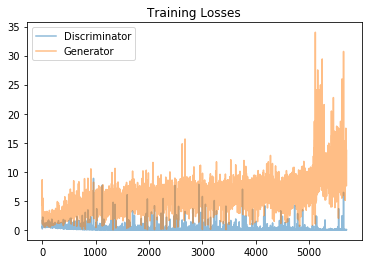

In [65]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [66]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [67]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

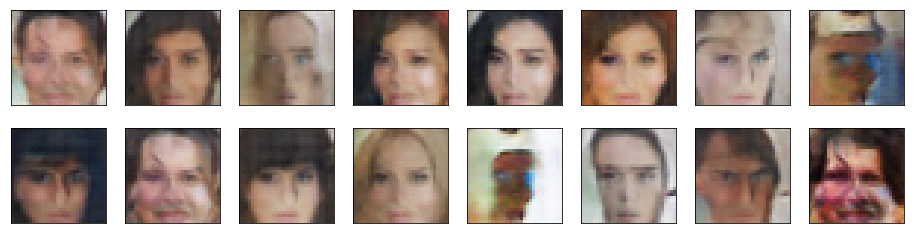

In [68]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
Most generated fases are white. To make the generated dataset more diverse, a

The complexity of the generator as well as the discriminator could increased by additional convolutional layer. If the model becomes to complex, ResNet units should be added.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.